## 1. Preparação do ambiente (Colab + Drive)

Esta célula monta o Google Drive e define os caminhos principais do projeto:

- Pasta base do desafio: `MyDrive/Desafio_Ligia`;
- Caminho do modelo final salvo em `.keras`;
- Raiz das imagens de raio-X (`Data/chest_xray`), mantendo a mesma estrutura utilizada na modelagem.

Também é garantido que o diretório de trabalho padrão seja `/content`, o que facilita a clonagem e o uso do repositório no Colab.

In [8]:
# 1. Configuração de caminhos (execução local, sem Colab/Drive)

from pathlib import Path
import sys

def encontrar_repo_root():
    """
    Localiza a raiz do projeto PS_Ligia_Desafio_Individual.

    Funciona nos cenários:
    - Notebook dentro de PS_Ligia_Desafio_Individual/Notebooks
    - Notebook aberto diretamente na raiz do projeto
    """
    here = Path.cwd()

    # Caso típico: notebook em PS_Ligia_Desafio_Individual/Notebooks
    if (here.parent / "data").exists() and (here.parent / "BestModel").exists():
        return here.parent

    # Caso o notebook esteja na raiz
    if (here / "data").exists() and (here / "BestModel").exists():
        return here

    # Fallback: sobe alguns níveis procurando data/ e BestModel/
    cur = here
    for _ in range(5):
        if (cur / "data").exists() and (cur / "BestModel").exists():
            return cur
        cur = cur.parent

    raise RuntimeError(
        "Não foi possível localizar a raiz do projeto.\n"
        "Estrutura esperada (resumida):\n"
        "PS_Ligia_Desafio_Individual/\n"
        "  ├─ BestModel/best_model.keras\n"
        "  └─ data/\n"
        "      ├─ dataset.csv\n"
        "      └─ chest_xray/{train,test}/..."
    )

# Raiz do projeto
REPO_ROOT = encontrar_repo_root()

# Caminho do modelo final em .keras
MODEL_PATH = REPO_ROOT / "BestModel" / "best_model.keras"

# Raiz das imagens de raio-X (data/chest_xray)
DATA_ROOT = REPO_ROOT / "data" / "chest_xray"

# Caminho do CSV tratado (data/dataset.csv)
CSV_PATH = REPO_ROOT / "data" / "dataset.csv"

# Checagens rápidas
assert MODEL_PATH.exists(), "Arquivo best_model.keras não encontrado em BestModel/best_model.keras."
assert DATA_ROOT.exists(), "Diretório data/chest_xray não encontrado."
assert CSV_PATH.exists(), "dataset.csv não encontrado em data/dataset.csv."

# Garante que o repositório está no sys.path para imports internos
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))
    print("sys.path atualizado com o repositório.")

## 2. Clonagem do repositório e configuração de caminhos

Esta célula:

- Clona o repositório público do projeto (caso ainda não exista em `/content`);
- Define `REPO_ROOT` como raiz do repositório;
- Adiciona o repositório ao `sys.path` para permitir imports dos módulos internos;
- Define o caminho para o arquivo `data/dataset.csv`, que contém o dataset já tratado (mesmo arquivo usado na etapa de modelagem).

Também é feita uma checagem para garantir que o `dataset.csv` está presente.

## 3. Imports principais e carregamento do `dataset.csv` tratado

Esta célula:

- Importa as bibliotecas principais (`tensorflow`, `numpy`, `pandas`, `matplotlib`);
- Importa a função `load_dataframe` do módulo `ImagePreprocessing/imagePipeline.py`;
- Carrega o `data/dataset.csv`, que já passou pelo pré-processamento de dados (limpeza, remoção de duplicatas, tratamento de outliers, criação da coluna `split` etc.);
- Exibe as colunas relevantes para conferência, em especial:

  - `image_path`: caminho relativo da imagem;
  - `class`: rótulo textual (`NORMAL` / `PNEUMONIA`);
  - `label`: rótulo numérico (0 / 1);
  - `split`: partição (`train`, `val`, `test`).

In [9]:
# 3. Imports principais e carregamento do dataset tratado

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from ImagePreprocessing.imagePipeline import load_dataframe

# Parâmetros compatíveis com o modelo treinado
IMG_SIZE = 224

print("CSV usado.....:", CSV_PATH.relative_to(REPO_ROOT))
print("Base das imagens (DATA_ROOT):", DATA_ROOT.relative_to(REPO_ROOT))

# Carrega o DataFrame tratado (dataset.csv)
df = load_dataframe(str(CSV_PATH))
print("DataFrame carregado com shape:", df.shape)

# Mantém apenas as colunas úteis
cols_to_show = [c for c in ["image_path", "filename", "class", "label", "split"] if c in df.columns]
df[cols_to_show].head()

# 3.1 Função auxiliar para obter o caminho completo da imagem

def full_image_path(rel_path: str | Path):
    
    return DATA_ROOT / Path(rel_path)

# Teste: 
sample = df.iloc[0]["image_path"]
full_path = full_image_path(sample)
print("Exemplo de caminho montado (relativo à raiz):", full_path.relative_to(REPO_ROOT))
assert full_path.exists(), "Erro: imagem do dataset não encontrada."

CSV usado.....: data/dataset.csv
Base das imagens (DATA_ROOT): data/chest_xray
DataFrame carregado com shape: (5856, 8)
Exemplo de caminho montado (relativo à raiz): data/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg


## 4. Carregamento do modelo final e pipeline de pré-processamento

Nesta célula:

- O modelo final `best_model.keras` é carregado (EfficientNetB0 com data augmentation e fine-tuning);
- É definida a função `full_image_path`, responsável por reconstruir o caminho absoluto da imagem a partir de `image_path` e da raiz `DATA_ROOT`;
- É definido o pipeline de pré-processamento `load_and_preprocess_with_pipeline`, que replica exatamente o fluxo de treino:

  1. Leitura do JPEG em escala de cinza (1 canal);
  2. `resize_with_pad` para `(224, 224)`;
  3. Conversão para RGB (3 canais);
  4. `efficientnet_preprocess` (pré-processamento da EfficientNet);

- É definida a função `predict_proba`, que calcula `p(PNEUMONIA)` para um tensor já pré-processado, assumindo saída `Dense(1, sigmoid)`.

In [10]:
# 4. Modelo final e pipeline de pré-processamento (igual ao treino)

from pathlib import Path
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Carrega o modelo final (EfficientNetB0 + aug + fine-tuning)
best_model = tf.keras.models.load_model(str(MODEL_PATH))
best_model.trainable = False
print("Modelo carregado:", MODEL_PATH.relative_to(REPO_ROOT))

CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

def full_image_path(rel_path: str | Path) -> Path:
    """
    Constrói o caminho completo da imagem a partir do caminho relativo
    presente no dataset.csv, usando a mesma raiz DATA_ROOT da modelagem.
    """
    return DATA_ROOT / str(rel_path)

def load_and_preprocess_with_pipeline(img_path: str | Path):
    """
    Aplica o MESMO pipeline 'transfer' usado no treino:

    - JPEG -> escala de cinza (1 canal)
    - resize_with_pad para (IMG_SIZE, IMG_SIZE)
    - grayscale_to_rgb
    - efficientnet_preprocess

    Retorna:
      - original_img_np: np.ndarray (H, W, 3) em [0,1] (para visualização)
      - input_tensor:   tf.Tensor (1, IMG_SIZE, IMG_SIZE, 3) pronto para o modelo
    """
    img_path = Path(img_path)

    # Leitura da imagem
    raw = tf.io.read_file(str(img_path))
    img = tf.image.decode_jpeg(raw, channels=1)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)

    # Converte para RGB (3 canais) como no preprocess_transfer
    img_rgb = tf.image.grayscale_to_rgb(img)

    # Versão para visualização (normalizada em [0,1])
    original_img = tf.cast(img_rgb, tf.float32) / 255.0
    original_img_np = original_img.numpy()

    # Versão para o modelo (pré-processamento da EfficientNet)
    x = efficientnet_preprocess(img_rgb)
    x = tf.expand_dims(x, axis=0)  # (1, H, W, 3)

    return original_img_np, x

def predict_proba(model: tf.keras.Model, x: tf.Tensor) -> float:
    """
    Retorna p(PNEUMONIA) para um tensor (1, H, W, 3).
    Assume saída binária Dense(1, sigmoid).
    """
    preds = model(x, training=False).numpy()
    if preds.shape[-1] == 1:
        return float(preds[0, 0])
    return float(preds[0, -1])

2026-02-20 19:27:02.523476: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Modelo carregado: BestModel/best_model.keras


## 5. Imports das técnicas de interpretabilidade (Saliency + LIME)

Esta célula prepara o ambiente para as técnicas de interpretabilidade utilizadas no projeto:

- Instala as dependências externas necessárias para o LIME (`lime` e `scikit-image`);
- Importa, do repositório, as funções de **saliency** (`compute_saliency_map`, `overlay_saliency`, `plot_saliency_result`);
- Importa, do repositório, as funções de **LIME** (`make_lime_predict_fn`, `explain_with_lime`, `plot_lime_result`);
- Importa classes auxiliares de `lime_image` e `skimage.segmentation`.

As funções de interpretabilidade serão aplicadas posteriormente em dois conjuntos distintos:
- Imagens do **conjunto de validação** (`split == "val"`);
- Imagens do **conjunto de teste interno** (`split == "test"`).

In [11]:
# 5. Imports específicos das técnicas de interpretabilidade

from Interpretability.saliency import (
    compute_saliency_map,
    overlay_saliency,
    plot_saliency_result,
)

from Interpretability.lime import (
    make_lime_predict_fn,
    explain_with_lime,
    plot_lime_result,
)

from lime import lime_image
from skimage.segmentation import mark_boundaries

## 6. Seleção de exemplos para interpretabilidade no conjunto de validação (`split == "val"`)

Nesta célula são selecionadas imagens do **conjunto de validação** para aplicação das técnicas de interpretabilidade.

Procedimento:

1. Filtra-se o `dataset.csv` para obter apenas as linhas com `split == "val"`;
2. Para este subconjunto, são separados os caminhos de imagens das classes `NORMAL` e `PNEUMONIA`;
3. É feita uma amostragem de até `N_PER_CLASS` imagens por classe;
4. Os exemplos selecionados são armazenados em uma lista `sampled_val`, contendo dicionários com:
   - `path`: caminho relativo da imagem (coluna `image_path`);
   - `label`: rótulo textual (`NORMAL` ou `PNEUMONIA`);
   - `split`: nome do split de origem (`"val"`).

Esses exemplos serão utilizados nas próximas células para geração de **saliency maps** e explicações com **LIME** sobre o conjunto de validação.

In [12]:
# 6. Seleção de exemplos para interpretabilidade no conjunto de validação

import random

random.seed(42)
N_PER_CLASS = 2

def sample_from_split(df_split, split_name, n_per_class=2):
    """
    Amostra até n_per_class imagens de cada classe (NORMAL / PNEUMONIA)
    dentro de um determinado split, retornando uma lista de dicionários
    com: path, label e split.
    """
    normal = df_split[df_split["class"] == "NORMAL"]["image_path"].tolist()
    pneu   = df_split[df_split["class"] == "PNEUMONIA"]["image_path"].tolist()

    sampled = []
    if normal:
        sampled += [
            {"path": p, "label": "NORMAL", "split": split_name}
            for p in random.sample(normal, min(n_per_class, len(normal)))
        ]
    if pneu:
        sampled += [
            {"path": p, "label": "PNEUMONIA", "split": split_name}
            for p in random.sample(pneu, min(n_per_class, len(pneu)))
        ]
    return sampled

# Filtra split de validação
if "split" in df.columns:
    df_val = df[df["split"] == "val"].copy()
else:
    df_val = df.copy()

sampled_val = []
if not df_val.empty:
    sampled_val = sample_from_split(df_val, split_name="val", n_per_class=N_PER_CLASS)

print("Imagens de validação selecionadas para interpretabilidade:")
for s in sampled_val:
    print(f"split={s['split']:>3} | {s['label']:9} -> {s['path']}")

assert len(sampled_val) > 0, "Nenhuma imagem de validação selecionada. Verificar colunas 'image_path', 'class' e 'split'."

Imagens de validação selecionadas para interpretabilidade:
split=val | NORMAL    -> train/NORMAL/NORMAL-2881863-0001.jpeg
split=val | NORMAL    -> train/NORMAL/NORMAL-1456124-0001.jpeg
split=val | PNEUMONIA -> train/PNEUMONIA/VIRUS-8201141-0001.jpeg
split=val | PNEUMONIA -> train/PNEUMONIA/BACTERIA-5965088-0002.jpeg


## 7. Saliency maps no conjunto de validação

Nesta célula são gerados **saliency maps** para as imagens selecionadas do conjunto de validação (`sampled_val`).

Para cada imagem:

1. Reconstrói-se o caminho absoluto a partir de `DATA_ROOT` e `image_path`;
2. A imagem é carregada e pré-processada com `load_and_preprocess_with_pipeline`, garantindo o mesmo pipeline usado no treino;
3. O modelo `best_model` calcula a probabilidade prevista de pneumonia (`p(PNEUMONIA)`);
4. É calculado o mapa de saliência via `compute_saliency_map`, considerando os gradientes da predição em relação à entrada;
5. É gerado um overlay (`overlay_saliency`) sobre a imagem original;
6. A função `plot_saliency_result` exibe:
   - imagem original;
   - saliency map em tons de cinza;
   - overlay com o mapa de saliência;
   - probabilidade prevista e rótulo verdadeiro.

O objetivo é visualizar quais regiões do raio-X mais influenciam a decisão do modelo no conjunto de validação.


[Saliency - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/NORMAL/NORMAL-2881863-0001.jpeg


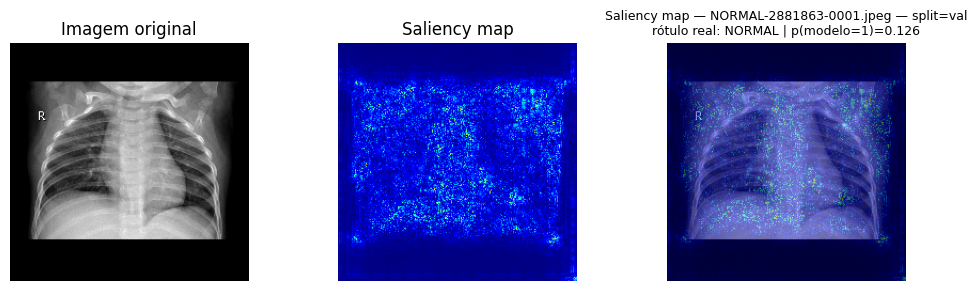


[Saliency - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/NORMAL/NORMAL-1456124-0001.jpeg


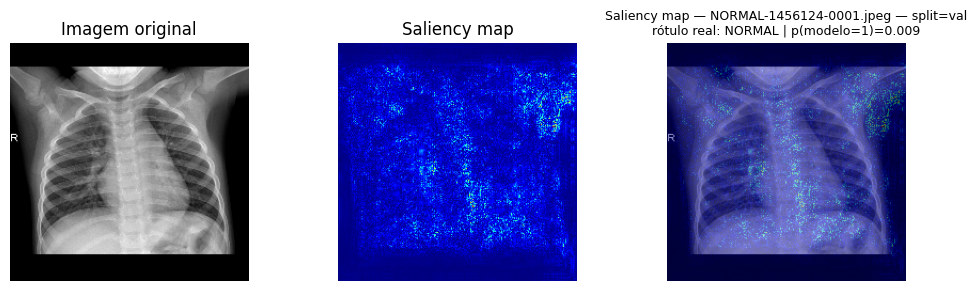


[Saliency - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/PNEUMONIA/VIRUS-8201141-0001.jpeg


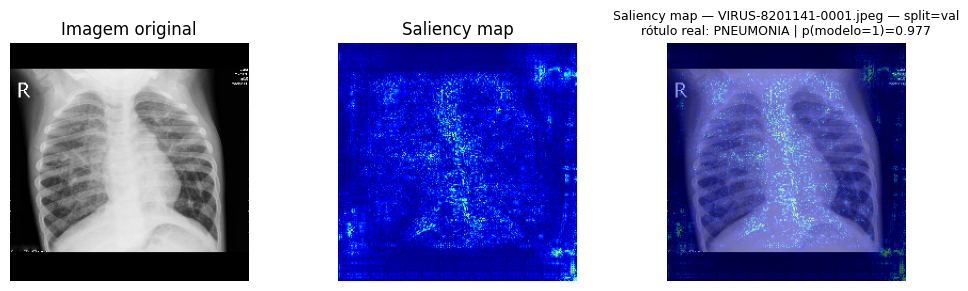


[Saliency - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/PNEUMONIA/BACTERIA-5965088-0002.jpeg


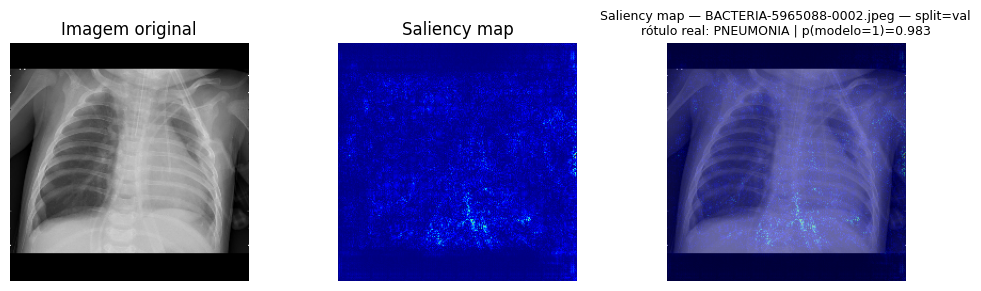

In [13]:
# 7. Saliency maps no conjunto de validação

for item in sampled_val:
    rel_path   = item["path"]
    true_label = item["label"]   # "NORMAL" ou "PNEUMONIA"
    split_name = item.get("split", "val")

    img_path = full_image_path(rel_path)
    print(f"\n[Saliency - VAL] Processando (split={split_name}):", img_path)

    # 1. Carrega imagem com o MESMO pipeline do modelo
    original_img, input_tensor = load_and_preprocess_with_pipeline(img_path)

    # 2. Probabilidade prevista (p(PNEUMONIA))
    prob = predict_proba(best_model, input_tensor)

    # 3. Calcula o saliency map sobre o tensor já pré-processado
    saliency = compute_saliency_map(
        input_tensor=input_tensor,
        model=best_model,
        class_index=None,   # binário: usa a saída padrão
        use_absolute=True,  # |gradiente|
    )

    # 4. Gera overlay na imagem original
    superimposed = overlay_saliency(
        original_image=original_img,
        saliency=saliency,
        alpha=0.45,
        cmap="jet",
    )

    # 5. Plota original + saliency + overlay
    title = f"Saliency map — {Path(rel_path).name} — split={split_name}"
    plot_saliency_result(
        original_image=original_img,
        saliency=saliency,
        superimposed_image=superimposed,
        title=title,
        prob=prob,
        true_label=true_label,
    )

## 8. Explicações locais com LIME no conjunto de validação

Esta célula aplica **LIME (Local Interpretable Model-agnostic Explanations)** às mesmas imagens do conjunto de validação utilizadas nos saliency maps.

Passos principais:

1. Cria-se uma função de predição compatível com o LIME (`lime_predict_fn`), utilizando o modelo final e o mesmo pré-processamento da EfficientNet;
2. Para cada imagem em `sampled_val`:
   - A imagem é carregada com `load_and_preprocess_with_pipeline` para manter a mesma resolução e geometria utilizadas no treino;
   - A versão de visualização é convertida para `uint8` (escala 0–255), formato esperado pelo LIME;
   - O modelo calcula `p(PNEUMONIA)` para a imagem;
   - A função `explain_with_lime` gera uma explicação local, destacando superpixels mais relevantes para a predição;
   - `plot_lime_result` exibe a imagem original ao lado da imagem com superpixels destacados, junto com probabilidade e rótulo verdadeiro.

O objetivo é complementar os saliency maps com uma explicação local baseada em superpixels, ainda no contexto do conjunto de validação.


[LIME - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/NORMAL/NORMAL-2881863-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

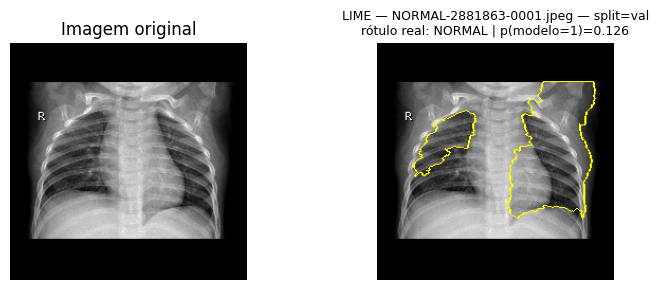


[LIME - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/NORMAL/NORMAL-1456124-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

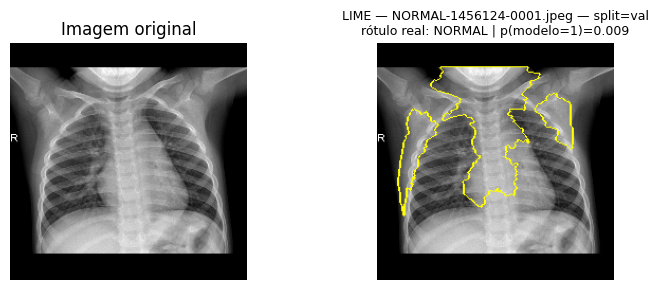


[LIME - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/PNEUMONIA/VIRUS-8201141-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

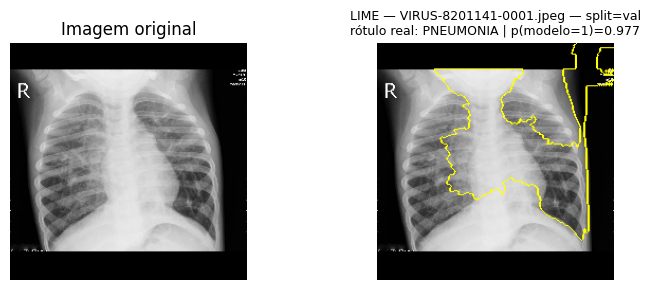


[LIME - VAL] Processando (split=val): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/train/PNEUMONIA/BACTERIA-5965088-0002.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

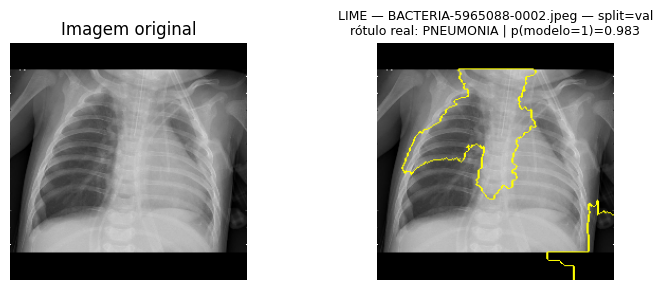

In [14]:
# 8. LIME no conjunto de validação

# Função de predição compatível com LIME (usa o modelo final)
lime_predict_fn = make_lime_predict_fn(
    model=best_model,
    img_size=IMG_SIZE,
    preprocess_fn=efficientnet_preprocess,
)

# Instanciador base do LIME (usado dentro de explain_with_lime)
explainer = lime_image.LimeImageExplainer()

for item in sampled_val:
    rel_path   = item["path"]
    true_label = item["label"]          # "NORMAL" ou "PNEUMONIA"
    split_name = item.get("split", "val")

    img_path = full_image_path(rel_path)
    print(f"\n[LIME - VAL] Processando (split={split_name}):", img_path)

    # 1. Carrega com o MESMO pipeline para obter a imagem já redimensionada
    original_img, input_tensor = load_and_preprocess_with_pipeline(img_path)

    # Converte para uint8 [0,255] para o LIME
    img_uint8 = (original_img * 255.0).astype(np.uint8)

    # 2. Probabilidade prevista (p(PNEUMONIA))
    prob = predict_proba(best_model, input_tensor)

    # 3. Aplica LIME utilizando o helper do módulo de interpretabilidade
    image_lime, mask = explain_with_lime(
        img_uint8=img_uint8,
        predict_fn=lime_predict_fn,
        num_samples=1000,
        positive_only=True,
        num_features=5,
    )

    # 4. Plota imagem original + explicação LIME
    title = f"LIME — {Path(rel_path).name} — split={split_name}"
    plot_lime_result(
        original_image=original_img,
        image_lime=image_lime,
        mask=mask,
        title=title,
        prob=prob,
        true_label=true_label,
    )

## 9. Seleção de exemplos para interpretabilidade no conjunto de teste interno (`split == "test"`)

Nesta célula são selecionadas imagens do **conjunto de teste interno** para aplicação das mesmas técnicas de interpretabilidade utilizadas na validação.

Procedimento:

1. Filtra-se o `dataset.csv` para obter apenas as linhas com `split == "test"`;
2. São separados os caminhos de imagens das classes `NORMAL` e `PNEUMONIA`;
3. É feita uma amostragem de até `N_PER_CLASS` imagens por classe;
4. Os exemplos selecionados são armazenados em `sampled_test_internal`, com:
   - `path`: caminho relativo da imagem;
   - `label`: rótulo textual (`NORMAL` ou `PNEUMONIA`);
   - `split`: `"test"`.

Esses exemplos permitem inspecionar o comportamento do modelo em dados que não participaram nem do treino nem da validação, aproximando-se do cenário de uso real.

In [15]:
# 9. Seleção de exemplos para interpretabilidade no conjunto de teste interno

if "split" in df.columns:
    df_test_internal_for_samples = df[df["split"] == "test"].copy()
else:
    df_test_internal_for_samples = pd.DataFrame(columns=df.columns)

sampled_test_internal = []
if not df_test_internal_for_samples.empty:
    sampled_test_internal = sample_from_split(
        df_test_internal_for_samples,
        split_name="test",
        n_per_class=N_PER_CLASS,
    )

print("Imagens de teste interno selecionadas para interpretabilidade:")
for s in sampled_test_internal:
    print(f"split={s['split']:>4} | {s['label']:9} -> {s['path']}")

assert len(sampled_test_internal) > 0, "Nenhuma imagem de teste interno selecionada. Verificar split == 'test'."

Imagens de teste interno selecionadas para interpretabilidade:
split=test | NORMAL    -> test/NORMAL/NORMAL-3396581-0001.jpeg
split=test | NORMAL    -> test/NORMAL/NORMAL-3267425-0001.jpeg
split=test | PNEUMONIA -> test/PNEUMONIA/BACTERIA-4059589-0001.jpeg
split=test | PNEUMONIA -> test/PNEUMONIA/VIRUS-9039335-0001.jpeg


## 10. Saliency maps no conjunto de teste interno

Nesta célula são gerados **saliency maps** para as imagens selecionadas do conjunto de teste interno (`sampled_test_internal`).

A lógica é análoga à utilizada na validação:

1. Reconstrói-se o caminho absoluto da imagem;
2. Aplica-se o mesmo pipeline de pré-processamento usado no treino;
3. O modelo calcula `p(PNEUMONIA)`;
4. O mapa de saliência é calculado sobre o tensor de entrada;
5. É produzido um overlay saliência + imagem original;
6. O resultado é exibido com informações de split, probabilidade e rótulo verdadeiro.

O objetivo é verificar se o modelo mantém padrões consistentes de atenção também em dados do teste interno, reforçando a análise de generalização.


[Saliency - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/NORMAL/NORMAL-3396581-0001.jpeg


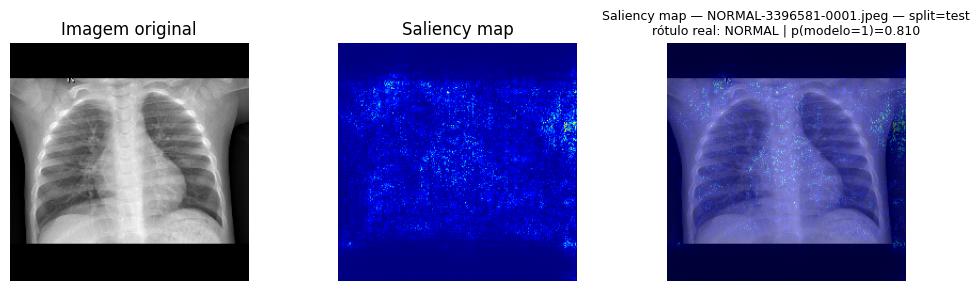


[Saliency - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/NORMAL/NORMAL-3267425-0001.jpeg


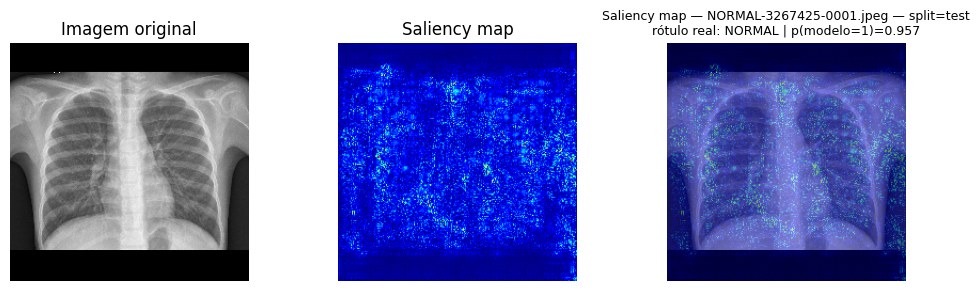


[Saliency - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/PNEUMONIA/BACTERIA-4059589-0001.jpeg


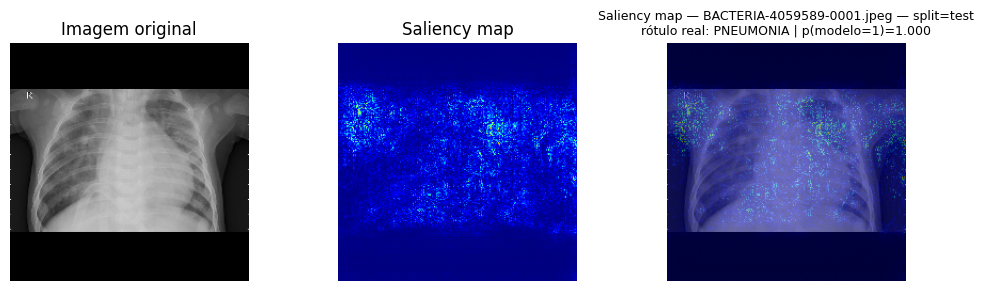


[Saliency - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/PNEUMONIA/VIRUS-9039335-0001.jpeg


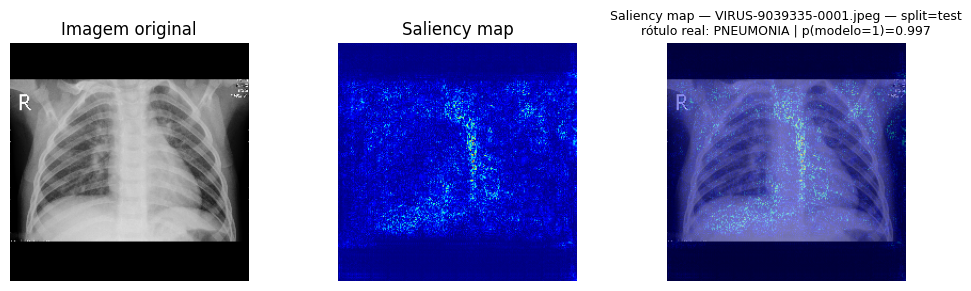

In [16]:
# 10. Saliency maps no conjunto de teste interno

for item in sampled_test_internal:
    rel_path   = item["path"]
    true_label = item["label"]   # "NORMAL" ou "PNEUMONIA"
    split_name = item.get("split", "test")

    img_path = full_image_path(rel_path)
    print(f"\n[Saliency - TEST] Processando (split={split_name}):", img_path)

    # 1. Carrega imagem com o MESMO pipeline do modelo
    original_img, input_tensor = load_and_preprocess_with_pipeline(img_path)

    # 2. Probabilidade prevista (p(PNEUMONIA))
    prob = predict_proba(best_model, input_tensor)

    # 3. Calcula o saliency map sobre o tensor já pré-processado
    saliency = compute_saliency_map(
        input_tensor=input_tensor,
        model=best_model,
        class_index=None,
        use_absolute=True,
    )

    # 4. Gera overlay na imagem original
    superimposed = overlay_saliency(
        original_image=original_img,
        saliency=saliency,
        alpha=0.45,
        cmap="jet",
    )

    # 5. Plota original + saliency + overlay
    title = f"Saliency map — {Path(rel_path).name} — split={split_name}"
    plot_saliency_result(
        original_image=original_img,
        saliency=saliency,
        superimposed_image=superimposed,
        title=title,
        prob=prob,
        true_label=true_label,
    )

## 11. Explicações locais com LIME no conjunto de teste interno

Esta célula aplica **LIME** às imagens do conjunto de teste interno (`sampled_test_internal`), utilizando a mesma configuração já utilizada para a validação.

Para cada imagem:

1. A imagem é carregada com o pipeline de pré-processamento oficial;
2. A versão de visualização é convertida para `uint8` (0–255);
3. O modelo produz `p(PNEUMONIA)`;
4. `explain_with_lime` gera uma explicação local, destacando superpixels que mais contribuíram para a decisão;
5. `plot_lime_result` exibe a imagem original e a imagem explicada, com indicação da probabilidade e do rótulo verdadeiro.

Dessa forma, a interpretabilidade cobre tanto o conjunto de validação quanto o conjunto de teste interno, atendendo ao requisito de evitar uma solução tratada como “caixa-preta”.


[LIME - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/NORMAL/NORMAL-3396581-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

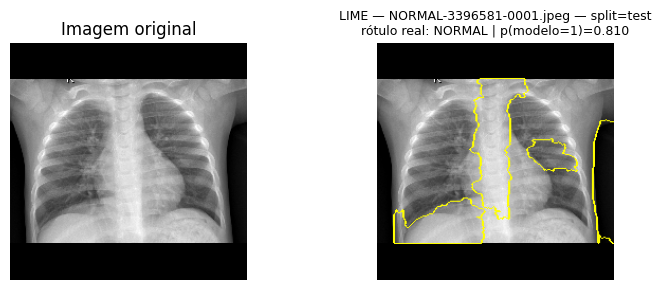


[LIME - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/NORMAL/NORMAL-3267425-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

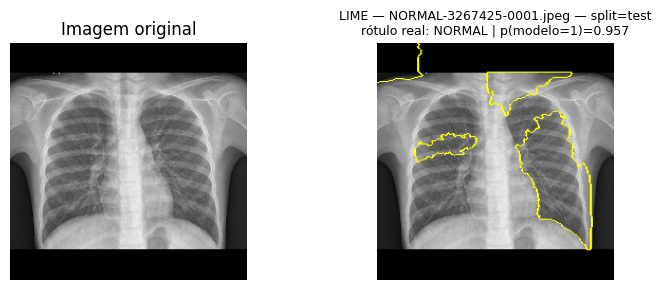


[LIME - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/PNEUMONIA/BACTERIA-4059589-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

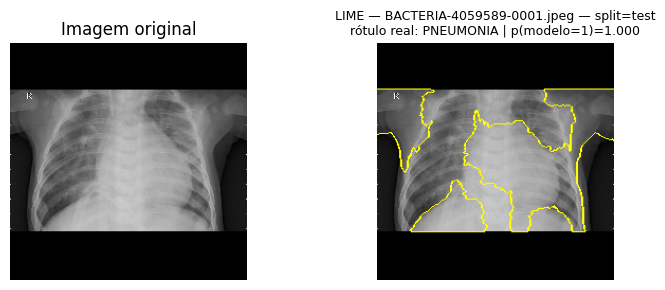


[LIME - TEST] Processando (split=test): /home/victoria/Desktop/PS_Ligia_Desafio_Individual/data/chest_xray/test/PNEUMONIA/VIRUS-9039335-0001.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

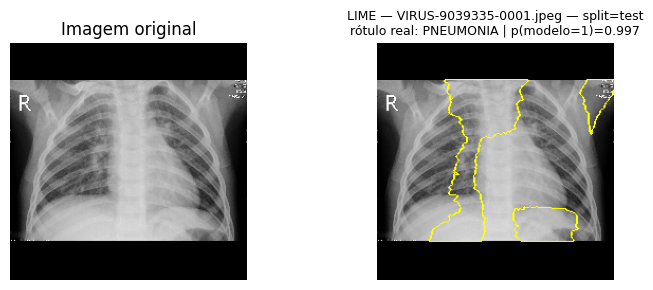

In [17]:
# 11. LIME no conjunto de teste interno

for item in sampled_test_internal:
    rel_path   = item["path"]
    true_label = item["label"]          # "NORMAL" ou "PNEUMONIA"
    split_name = item.get("split", "test")

    img_path = full_image_path(rel_path)
    print(f"\n[LIME - TEST] Processando (split={split_name}):", img_path)

    # 1. Carrega com o MESMO pipeline para obter a imagem já redimensionada
    original_img, input_tensor = load_and_preprocess_with_pipeline(img_path)

    # Converte para uint8 [0,255] para o LIME
    img_uint8 = (original_img * 255.0).astype(np.uint8)

    # 2. Probabilidade prevista (p(PNEUMONIA))
    prob = predict_proba(best_model, input_tensor)

    # 3. Aplica LIME utilizando o helper do módulo de interpretabilidade
    image_lime, mask = explain_with_lime(
        img_uint8=img_uint8,
        predict_fn=lime_predict_fn,
        num_samples=1000,
        positive_only=True,
        num_features=5,
    )

    # 4. Plota imagem original + explicação LIME
    title = f"LIME — {Path(rel_path).name} — split={split_name}"
    plot_lime_result(
        original_image=original_img,
        image_lime=image_lime,
        mask=mask,
        title=title,
        prob=prob,
        true_label=true_label,
    )

## 12. Inferência e métricas no conjunto de teste interno (`split == "test"`)

Esta célula avalia o desempenho do modelo no **conjunto de teste interno**, definido como as linhas do `dataset.csv` com `split == "test"`.



In [18]:
# 12. Inferência do modelo no conjunto de teste interno (split == "test")

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)
from pathlib import Path

# Verifica se existe coluna 'split'
if "split" not in df.columns:
    raise RuntimeError("A coluna 'split' não existe no dataset.csv. Não é possível separar o teste interno.")

# Filtra o conjunto de teste interno a partir do dataset.csv tratado
df_test_internal = df[df["split"] == "test"].copy()
print("df_test_internal shape:", df_test_internal.shape)

cols_view = [c for c in ["image_path", "class", "label", "split"] if c in df_test_internal.columns]
display(df_test_internal[cols_view].head())

assert not df_test_internal.empty, "O split 'test' do dataset.csv está vazio. Verificar o arquivo."

# Caminhos completos das imagens de teste interno
df_test_internal["filepath"] = df_test_internal["image_path"].apply(
    lambda p: str(full_image_path(p))
)

y_true_test_internal = []
y_score_test_internal = []
y_pred_test_internal = []

for idx, row in df_test_internal.iterrows():
    img_path = Path(row["filepath"])
    y_true = int(row["label"])  # 0 = NORMAL, 1 = PNEUMONIA

    # Carrega e pré-processa a imagem com o MESMO pipeline usado no treino
    _, x = load_and_preprocess_with_pipeline(img_path)

    # Probabilidade prevista de PNEUMONIA
    score = predict_proba(best_model, x)

    # Predição binária com limiar 0,5
    y_hat = 1 if score >= 0.5 else 0

    y_true_test_internal.append(y_true)
    y_score_test_internal.append(score)
    y_pred_test_internal.append(y_hat)

y_true_test_internal = np.array(y_true_test_internal)
y_score_test_internal = np.array(y_score_test_internal)
y_pred_test_internal = np.array(y_pred_test_internal)

print("Total de amostras de teste interno avaliadas:", len(y_true_test_internal))

# Cálculo das métricas no teste interno
test_internal_metrics = {}

# ROC AUC (usa probabilidades)
try:
    test_internal_metrics["roc_auc"] = roc_auc_score(y_true_test_internal, y_score_test_internal)
except ValueError as e:
    print("Não foi possível calcular ROC AUC:", e)
    test_internal_metrics["roc_auc"] = np.nan

# Demais métricas (usam predição binária)
test_internal_metrics["accuracy"] = accuracy_score(y_true_test_internal, y_pred_test_internal)
test_internal_metrics["recall"] = recall_score(y_true_test_internal, y_pred_test_internal, zero_division=0)
test_internal_metrics["precision"] = precision_score(y_true_test_internal, y_pred_test_internal, zero_division=0)
test_internal_metrics["f1"] = f1_score(y_true_test_internal, y_pred_test_internal, zero_division=0)

print("Métricas no conjunto de teste interno:")
for k, v in test_internal_metrics.items():
    print(f"  {k}: {v:.4f}")

df_test_internal shape: (624, 8)


,image_path,class,label,split
5232,test/NORMAL/NORMAL-1049278-0001.jpeg,NORMAL,0,test
5233,test/NORMAL/NORMAL-1110860-0001.jpeg,NORMAL,0,test
5234,test/NORMAL/NORMAL-11419-0001.jpeg,NORMAL,0,test
5235,test/NORMAL/NORMAL-115218-0001.jpeg,NORMAL,0,test
5236,test/NORMAL/NORMAL-1160949-0001.jpeg,NORMAL,0,test


Total de amostras de teste interno avaliadas: 624
Métricas no conjunto de teste interno:
  roc_auc: 0.9829
  accuracy: 0.8718
  recall: 0.9872
  precision: 0.8370
  f1: 0.9059


## 13. Gráfico com as métricas do conjunto de teste interno

Esta célula gera um gráfico de barras com todas as métricas calculadas para o conjunto de teste interno:

- ROC AUC;
- Acurácia;
- Recall;
- Precision;
- F1-score.



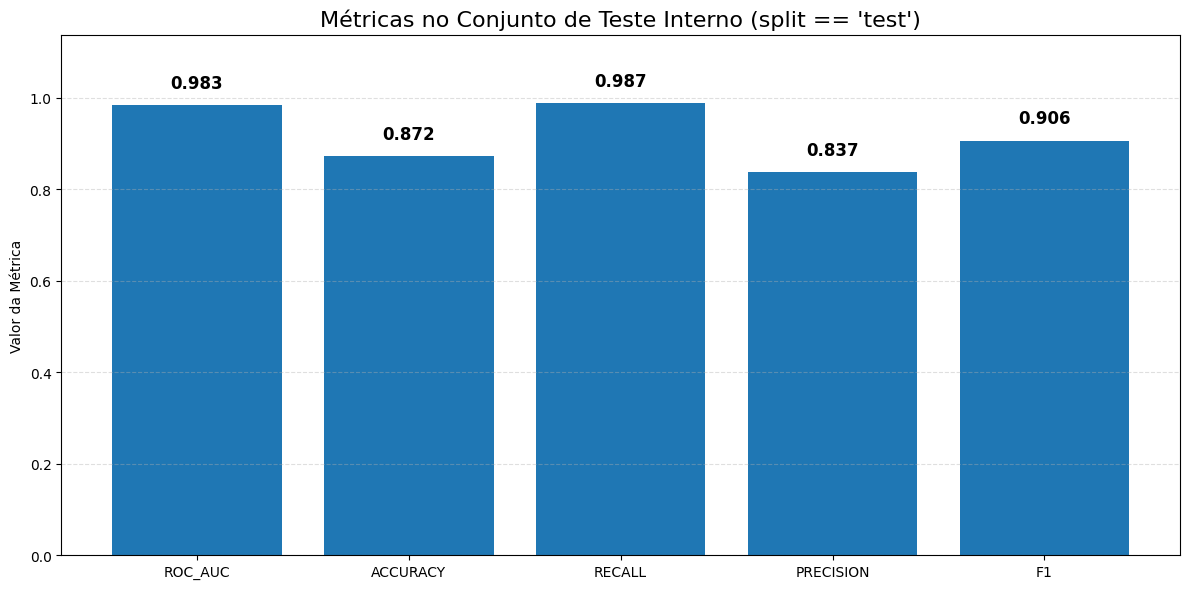

In [19]:
# 13. Gráfico único com todas as métricas do conjunto de teste interno

import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ["roc_auc", "accuracy", "recall", "precision", "f1"]
values = [test_internal_metrics[m] for m in metrics_to_plot]

plt.figure(figsize=(12, 6))

bars = plt.bar([m.upper() for m in metrics_to_plot], values)

# Ajuste automático da altura máxima (20% acima da maior métrica)
max_val = max(values)
plt.ylim(0, max_val + 0.15)

plt.title("Métricas no Conjunto de Teste Interno (split == 'test')", fontsize=16)
plt.ylabel("Valor da Métrica")

# Exibe valores numéricos acima das barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.03,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## 14. Inferência e métricas no conjunto de validação (`split == "val"`)

Nesta célula, o modelo final (`best_model.keras`) é avaliado no **conjunto de validação**, definido como todas as amostras do `dataset.csv` cujo `split` é `"val"`.


In [20]:
# 14. Inferência no conjunto de validação (split == "val")

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

# Verifica se existe coluna 'split'
if "split" not in df.columns:
    raise RuntimeError("A coluna 'split' não existe no dataset.csv. Não é possível separar a validação.")

# Filtra o conjunto de validação
df_val_inference = df[df["split"] == "val"].copy()
print("df_val_inference shape:", df_val_inference.shape)

cols_view = [c for c in ["image_path", "class", "label", "split"] if c in df_val_inference.columns]
display(df_val_inference[cols_view].head())

assert not df_val_inference.empty, "O split 'val' do dataset.csv está vazio. Verifique o arquivo."

# Caminhos completos das imagens de validação
df_val_inference["filepath"] = df_val_inference["image_path"].apply(
    lambda p: str(full_image_path(p))
)

y_true_val = []
y_score_val = []
y_pred_val = []

for idx, row in df_val_inference.iterrows():
    img_path = Path(row["filepath"])
    y_true = int(row["label"])  # 0 = NORMAL, 1 = PNEUMONIA

    # Carrega e pré-processa a imagem com o pipeline oficial
    _, x = load_and_preprocess_with_pipeline(img_path)

    # Probabilidade prevista de PNEUMONIA
    score = predict_proba(best_model, x)

    # Predição binária com limiar 0,5
    y_hat = 1 if score >= 0.5 else 0

    y_true_val.append(y_true)
    y_score_val.append(score)
    y_pred_val.append(y_hat)

y_true_val = np.array(y_true_val)
y_score_val = np.array(y_score_val)
y_pred_val = np.array(y_pred_val)

print("Total de amostras de validação avaliadas:", len(y_true_val))

# Cálculo das métricas no conjunto de validação
val_metrics = {}

# ROC AUC
try:
    val_metrics["roc_auc"] = roc_auc_score(y_true_val, y_score_val)
except ValueError as e:
    print("Não foi possível calcular ROC AUC:", e)
    val_metrics["roc_auc"] = np.nan

# Demais métricas
val_metrics["accuracy"] = accuracy_score(y_true_val, y_pred_val)
val_metrics["recall"] = recall_score(y_true_val, y_pred_val, zero_division=0)
val_metrics["precision"] = precision_score(y_true_val, y_pred_val, zero_division=0)
val_metrics["f1"] = f1_score(y_true_val, y_pred_val, zero_division=0)

print("\nMétricas no conjunto de validação:")
for k, v in val_metrics.items():
    print(f"  {k}: {v:.4f}")

df_val_inference shape: (1085, 8)


,image_path,class,label,split
4147,train/NORMAL/NORMAL-1012843-0001.jpeg,NORMAL,0,val
4148,train/NORMAL/NORMAL-1029510-0001.jpeg,NORMAL,0,val
4149,train/NORMAL/NORMAL-1068326-0001.jpeg,NORMAL,0,val
4150,train/NORMAL/NORMAL-1070073-0001.jpeg,NORMAL,0,val
4151,train/NORMAL/NORMAL-1070073-0002.jpeg,NORMAL,0,val


Total de amostras de validação avaliadas: 1085

Métricas no conjunto de validação:
  roc_auc: 0.9969
  accuracy: 0.9779
  recall: 0.9852
  precision: 0.9852
  f1: 0.9852


## 15. Gráfico com as métricas do conjunto de validação

Esta célula gera um gráfico de barras com as métricas calculadas para o conjunto de validação (`val_metrics`):

- ROC AUC  
- Acurácia  
- Recall  
- Precision  
- F1-score  



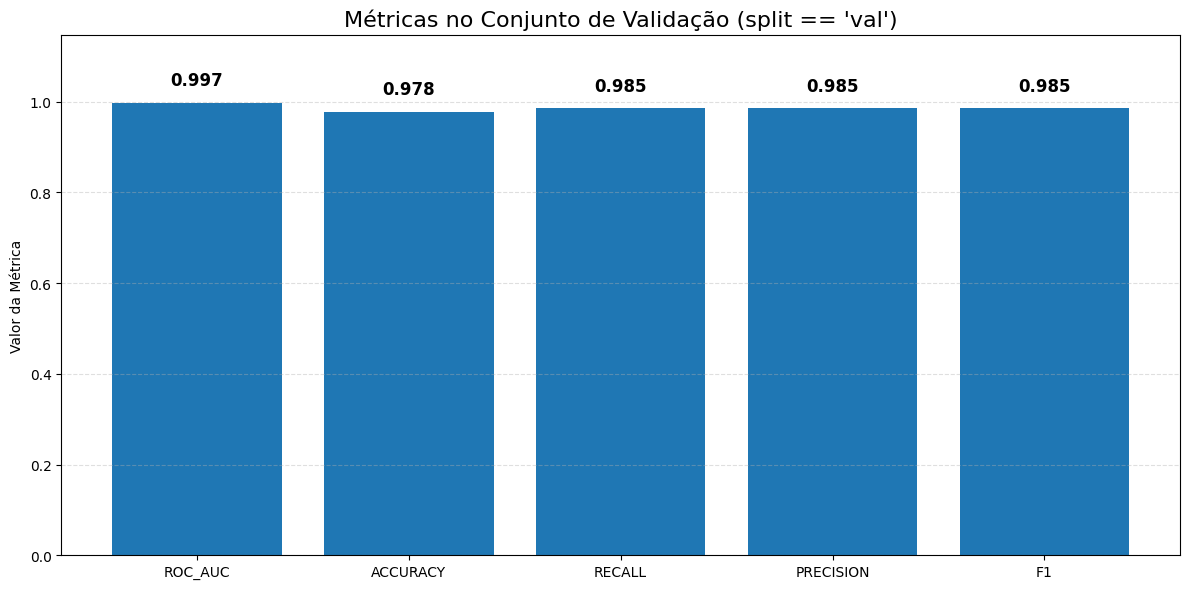

In [21]:
# 15. Gráfico único com todas as métricas do conjunto de validação

import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot_val = ["roc_auc", "accuracy", "recall", "precision", "f1"]
values_val = [val_metrics[m] for m in metrics_to_plot_val]

plt.figure(figsize=(12, 6))

bars = plt.bar([m.upper() for m in metrics_to_plot_val], values_val)

# Ajuste automático da altura máxima (20% acima da maior métrica)
max_val = max(values_val)
plt.ylim(0, max_val + 0.15)

plt.title("Métricas no Conjunto de Validação (split == 'val')", fontsize=16)
plt.ylabel("Valor da Métrica")

# Exibe valores numéricos acima das barras
for bar, value in zip(bars, values_val):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.03,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 16. Gráfico comparando validação x teste interno

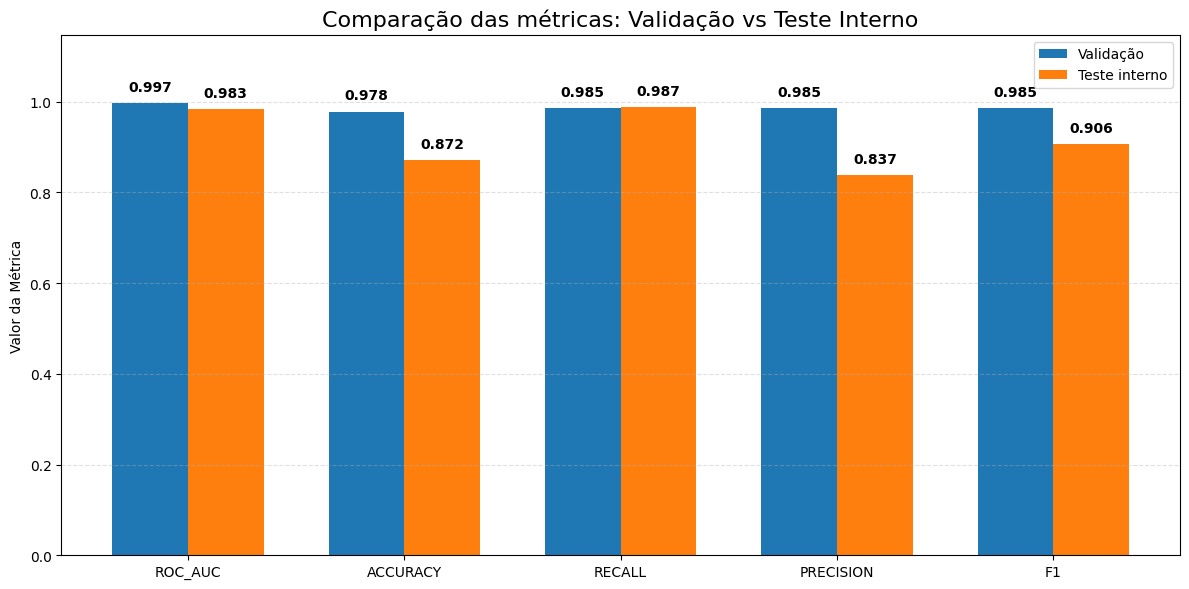

In [22]:
# 16. Gráfico comparando validação x teste interno (val_metrics vs test_internal_metrics)

import matplotlib.pyplot as plt
import numpy as np

# Métricas que serão comparadas
metrics = ["roc_auc", "accuracy", "recall", "precision", "f1"]

val_values = [val_metrics[m] for m in metrics]
test_values = [test_internal_metrics[m] for m in metrics]

x = np.arange(len(metrics))          # posições no eixo x
width = 0.35                         # largura de cada barra

plt.figure(figsize=(12, 6))

bars_val = plt.bar(x - width/2, val_values, width, label="Validação")
bars_test = plt.bar(x + width/2, test_values, width, label="Teste interno")

# Define rótulos do eixo x com os nomes das métricas em maiúsculo
plt.xticks(x, [m.upper() for m in metrics])

# Ajusta o limite superior do eixo y
max_val = max(val_values + test_values)
plt.ylim(0, max_val + 0.15)

plt.title("Comparação das métricas: Validação vs Teste Interno", fontsize=16)
plt.ylabel("Valor da Métrica")
plt.legend()

# Função auxiliar para escrever os valores numéricos acima de cada barra
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

autolabel(bars_val)
autolabel(bars_test)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()